<a href="https://colab.research.google.com/github/anurag965/ML-Content/blob/main/text_no_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
from google.colab import drive

In [52]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import os
import sys
import math
import shutil
import warnings
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from zipfile import ZipFile
from tqdm import trange
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(100)
LEVEL = 'level_1'

In [54]:
CONFIG = {"TEST_FOLDER" : "/content/drive/MyDrive/DATASETS/kaggle_level_1",
    "TRAIN_FOLDER" : "/content/drive/MyDrive/DATASETS/level_1",
    "IMAGE_SIZE": (16, 16),
    "THRESHOLD": 0.7}

In [55]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        image = image.convert("L")
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [56]:
languages = ['ta', 'hi', 'en']

images_train = read_all(f'{CONFIG["TRAIN_FOLDER"]}/background/', key_prefix='bgr_') # change the path
for language in languages:
  images_train.update(read_all(f'{CONFIG["TRAIN_FOLDER"]}/{language}/', key_prefix=language+"_"))
print(len(images_train))

images_test = read_all(CONFIG["TEST_FOLDER"], key_prefix='') # change the path
print(len(images_test))

Reading:


<ipython-input-55-7594fb431dc1>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):


  0%|          | 0/447 [00:00<?, ?it/s]

Reading:


  0%|          | 0/146 [00:00<?, ?it/s]

Reading:


  0%|          | 0/149 [00:00<?, ?it/s]

Reading:


  0%|          | 0/150 [00:00<?, ?it/s]

892
Reading:


  0%|          | 0/297 [00:00<?, ?it/s]

297


In [57]:
X_train = []
Y_train = []
for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)

X = np.array(X_train)
Y = np.array(Y_train)
X_test = np.array(X_test)

print(X.shape, Y.shape)
print(X_test.shape)

(892, 256) (892,)
(297, 256)


In [58]:
def plot_images(images,labels,columns=5,image_size=None,figsize=(8,8),cmap='gray'):
    fig = plt.figure(figsize=figsize)
    fig.tight_layout(h_pad=3)
    rows=math.ceil(len(images)/columns) # size of image array = numrows * numcolumns
    for image,label,position in zip(images,labels,range(1,len(labels)+1)):
        fig.add_subplot(rows,columns,position)
        if image_size is not None:
            image = image.reshape(image_size)
        plt.imshow(image,cmap=cmap,interpolation='nearest')
        plt.axis('off')
        plt.title(label)
    plt.show()

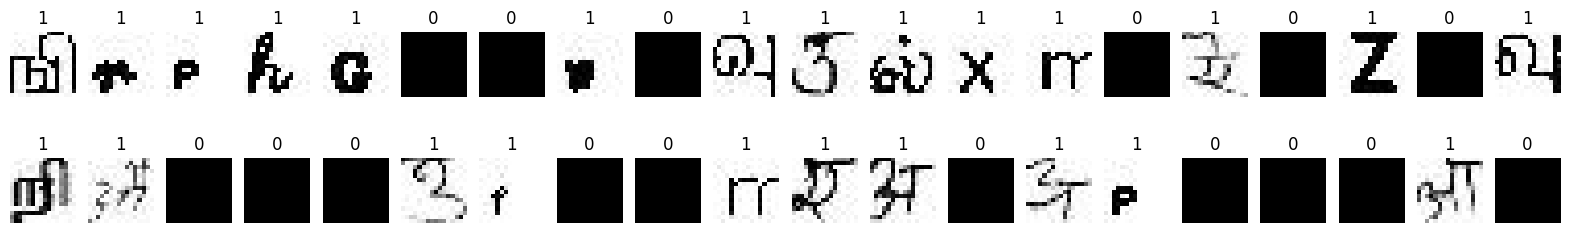

In [59]:
indexs = np.random.randint(1, X.shape[0], size=40) # get few random indexes
plot_images(X[indexs], Y[indexs], image_size=CONFIG["IMAGE_SIZE"], columns=20, figsize=(20, 3))

In [60]:
# splitting for train and validation sets to check bias chances on test data. we already have the test data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=10, stratify=Y, shuffle=True)

In [61]:
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
print(Y.mean(), Y_train.mean(), Y_val.mean())

(758, 256) (758,) (134, 256) (134,)
0.49887892376681614 0.49868073878627966 0.5


In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

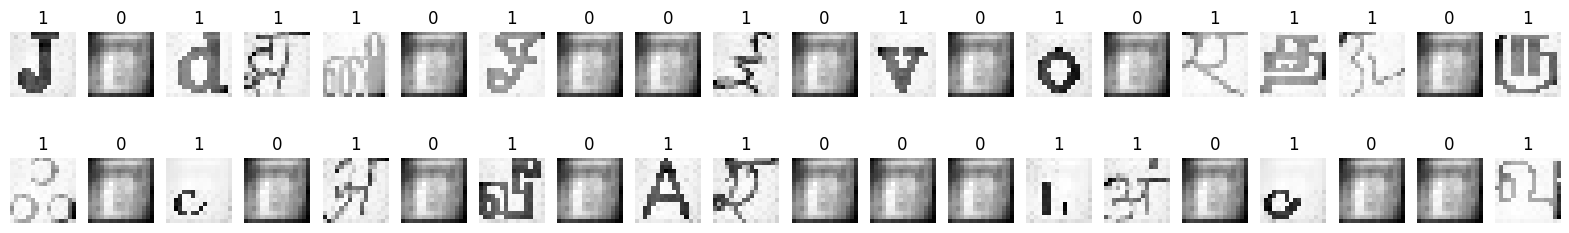

In [63]:
indexs = np.random.randint(1, X_train.shape[0], size=40)
plot_images(X_train[indexs], Y_train[indexs], image_size=CONFIG["IMAGE_SIZE"], columns=20, figsize=(20, 3))

In [64]:
class SigmoidNeuron:
    def __init__(self):
        self.w = None
        self.b = None
        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []

    def model(self, x):
        return 1. / (1. + np.exp(- (np.dot(self.w, x) + self.b)))

    def predict(self, X):
        return np.asarray([self.model(x) for x in X])

    def loss(self, Y, Y_pred):
        return log_loss(Y, Y_pred)

    def accuracy(self, Y, Y_pred):
        return accuracy_score(Y, (Y_pred >= CONFIG["THRESHOLD"]).astype(int))

    def grad_w(self, x, y, y_pred):
        return (y_pred - y) * x

    def grad_b(self, y, y_pred):
        return y_pred - y

    def fit(self, X_train, Y_train, X_val, Y_val, epochs=1, learning_rate=1, initialise=True):
        if initialise:
            self.w = np.random.randn(1, X_train.shape[1])
            self.b = 0

        for _ in tqdm(range(epochs), total=epochs, unit='epoch', desc='Epoch'):
            Y_pred = self.predict(X_train)

            dw = 0
            db = 0
            for x, y, y_pred in zip(X_train, Y_train, Y_pred):
                dw += self.grad_w(x, y, y_pred)
                db += self.grad_b(y, y_pred)

            self.w -= (learning_rate * dw)
            self.b -= (learning_rate * db)

            Y_pred = self.predict(X_train)
            self.train_loss.append(self.loss(Y_train, Y_pred))
            self.train_accuracy.append(self.accuracy(Y_train, Y_pred))

            Y_val_pred = self.predict(X_val)
            self.val_loss.append(self.loss(Y_val, Y_val_pred))
            self.val_accuracy.append(self.accuracy(Y_val, Y_val_pred))

        print('Final Train Loss:', self.train_loss[-1])
        print('Final Validation Loss:', self.val_loss[-1])
        print('Final Train Accuracy:', self.train_accuracy[-1])
        print('Final Validation Accuracy:', self.val_accuracy[-1])

    def plot_graphs(self):
        plt.plot(self.train_loss, label='Train Loss')
        plt.plot(self.val_loss, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Log Loss Error')
        plt.legend()
        plt.show()

        plt.plot(self.train_accuracy, label='Train Accuracy')
        plt.plot(self.val_accuracy, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    def evalute(self, X_test, Y_test):
        Y_test_pred = self.predict(X_test)
        print('Test Accuracy:', self.accuracy(Y_test, Y_test_pred))

Epoch:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Final Train Loss: 6.559665397987329e-06
Final Validation Loss: 0.694804368634494
Final Train Accuracy: 1.0
Final Validation Accuracy: 0.9776119402985075


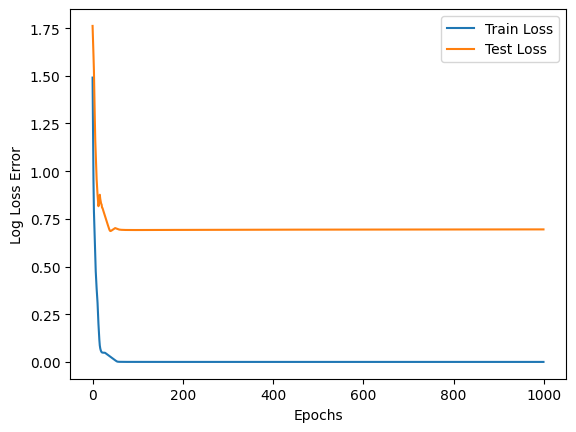

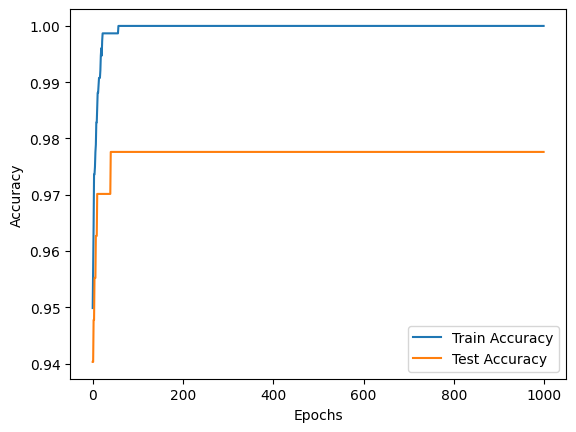

In [65]:
model = SigmoidNeuron()
model.fit(X_train, Y_train, X_val, Y_val, epochs=1000, learning_rate=0.02)
model.plot_graphs()

In [66]:
Y_test_pred = model.predict(X_test)
Y_test_pred = (Y_test_pred >= CONFIG["THRESHOLD"]).astype(int).ravel() # binarizing results
Y_test_pred

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1])

In [67]:
ID_test = np.append(ID_test, [19, 242,286])
Y_test_pred = np.append(Y_test_pred, [1, 0, 0])
print(Y_test_pred)

[1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1
 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1
 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1
 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1
 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1
 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0
 1 1 0 0]


In [68]:
submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_test_pred


submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
print(submission.shape)
submission.to_csv("submisision.csv", index=False)

(300, 2)
